In [ ]:
import torch
import torch.nn as nn
from torchtext.legacy import datasets
from torchtext.legacy import data
import numpy as np
import random
import time
import math
import matplotlib.pyplot as plt
import spacy


In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [ ]:
spacy_german = spacy.load("de_core_news_sm")
spacy_english =spacy.load("en_core_web_sm")

In [ ]:
def tokenize_german(text):
  return [tok.text for tok in spacy_german.tokenizer(text)]
  
def tokenize_english(text):
  return [tok.text for tok in spacy_english.tokenizer(text)]

In [ ]:
source=data.Field(init_token="<sos>",eos_token="<eos>",lower=True,batch_first=True,tokenize=tokenize_german)
target=data.Field(init_token="<sos>",eos_token="<eos>",lower=True,batch_first=True,tokenize=tokenize_english)

In [ ]:
train_data,valid_data,test_data = datasets.Multi30k.splits(exts=(".de",".en"),fields=(source,target))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 510kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 88.9kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 82.4kB/s]


In [ ]:
source.build_vocab(train_data,min_freq=2)
target.build_vocab(train_data,min_freq=2)

In [ ]:
if torch.cuda.is_available():
  device="cuda"
else:
  device="cpu"

In [ ]:
device

'cuda'

In [ ]:
train_iterator,valid_iterator,test_iterator=data.BucketIterator.splits((train_data,valid_data,test_data),batch_size=64,device=device)

In [ ]:
batch=next(iter(train_iterator))

In [ ]:
batch.src.shape

torch.Size([64, 25])

In [ ]:
class encoder(nn.Module):
  def __init__(self,input_dim,hid_dim,n_heads,pf_dim,n_layers,dropout,device,max_length=100):
    super().__init__()
    self.input_dim = input_dim
    self.hid_dim = hid_dim
    self.device = device
    self.tok_embedding = nn.Embedding(input_dim,hid_dim)
    self.pos_embedding = nn.Embedding(max_length,hid_dim)

    self.layers = nn.ModuleList([Encodelayer(hid_dim,n_heads,pf_dim,dropout,device) for _ in range(n_layers)])
    self.scale=torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
    self.dropout = nn.Dropout(dropout)

  def forward(self,src,src_mask):
    batch_size = src.shape[0]
    src_len = src.shape[1]

    pos = torch.arange(0,src_len).unsqueeze(0).repeat(batch_size,1).to(self.device)
    src = self.dropout((self.tok_embedding(src)*self.scale)+self.pos_embedding(pos))

    for layer in self.layers:
      src=layer(src,src_mask)

    return src


In [ ]:
class Encodelayer(nn.Module):
  def __init__(self,hid_dim,n_heads,pf_dim,dropout,device):
    super().__init__()
    self.attention_layer=MultiHeadAttention(hid_dim,n_heads,dropout,device)
    self.attn_layer_norm = nn.LayerNorm(hid_dim)
    self.pff_norm = nn.LayerNorm(hid_dim)
    self.positionfeedforward=positionfeedforward(hid_dim,pf_dim,dropout,device)
    self.dropout = nn.Dropout(dropout)

  def forward(self,src,src_mask):

    _src,_ = self.attention_layer(src,src,src,src_mask)
    src    = self.attn_layer_norm(src + self.dropout(_src))

    _src = self.positionfeedforward(src)
    src = self.pff_norm(src+self.dropout(_src))


    return src 

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self,hid_dim,n_heads,dropout,device):
    super().__init__()

    self.hid_dim = hid_dim
    self.n_heads = n_heads
    self.head_dim = hid_dim // n_heads

    self.fc_q = nn.Linear(hid_dim,hid_dim)
    self.fc_k = nn.Linear(hid_dim,hid_dim)
    self.fc_v = nn.Linear(hid_dim,hid_dim)
    self.fc_out = nn.Linear(hid_dim,hid_dim)
    self.scale=torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
    self.dropout = nn.Dropout(dropout)
    


  def forward(self,query,key,value,mask=None):
    batch_size = query.shape[0]
    

    q=self.fc_q(query)
    #[batch_size,q_len,hid_dim]
    k=self.fc_k(key)
    v=self.fc_v(value)

    q=q.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
    k=k.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
    v=v.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)

    energy = torch.matmul(q,k.permute(0,1,3,2))/self.scale

    if mask is not None:
      energy=energy.masked_fill(mask==0,-1e10)

    attention = torch.softmax(energy,dim=-1)

    x=torch.matmul(self.dropout(attention),v)

    x=x.permute(0,2,1,3).contiguous()

    x=x.view(batch_size,-1,self.hid_dim)

    x=self.fc_out(x)

    return x,attention

In [ ]:
class positionfeedforward(nn.Module):
  def __init__(self,hid_dim,pf_dim,dropout,device):
    super().__init__()
    self.lin1 = nn.Linear(hid_dim,pf_dim)
    self.lin2 = nn.Linear(pf_dim,hid_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self,src):
    src =self.dropout(torch.relu(self.lin1(src)))
    src=self.lin2(src)

    return src

In [ ]:
class decoder(nn.Module):
  def __init__(self,output_dim,hid_dim,n_heads,pf_dim,n_layers,dropout,device,max_length=100):
    super().__init__()
    self.output_dim=output_dim
    self.hid_dim = hid_dim
    self.device = device
    self.tok_embedding = nn.Embedding(input_dim,hid_dim)
    self.pos_embedding = nn.Embedding(max_length,hid_dim)

    self.layers = nn.ModuleList([Decodelayer(hid_dim,n_heads,pf_dim,dropout,device) for _ in range(n_layers)])
    self.scale=torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
    self.fc_out = nn.Linear(hid_dim, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self,trg,trg_mask,src,src_mask):
    batch_size = trg.shape[0]
    trg_len = trg.shape[1]

    pos = torch.arange(0,trg_len).unsqueeze(0).repeat(batch_size,1).to(self.device)
    trg = self.dropout((self.tok_embedding(trg)*self.scale)+self.pos_embedding(pos))

    for layer in self.layers:
      trg,attention=layer(trg,trg_mask,src,src_mask)

    
    trg = self.fc_out(trg)

    return trg,attention

In [ ]:
class Decodelayer(nn.Module):
  def __init__(self,hid_dim,n_heads,pf_dim,dropout,device):
    super().__init__()
    self.attention_layer=MultiHeadAttention(hid_dim,n_heads,dropout,device)
    self.encoderdecoder = MultiHeadAttention(hid_dim,n_heads,dropout,device)
    self.encdecnorm = nn.LayerNorm(hid_dim)
    self.attn_layer_norm = nn.LayerNorm(hid_dim)
    self.pff_norm = nn.LayerNorm(hid_dim)
    self.positionfeedforward=positionfeedforward(hid_dim,pf_dim,dropout,device)
    self.dropout = nn.Dropout(dropout)

  def forward(self,trg,trg_mask,src,src_mask):

    _trg,_ = self.attention_layer(trg,trg,trg,trg_mask)
    trg    = self.attn_layer_norm(trg + self.dropout(_trg))

    _trg,attention=self.encoderdecoder(trg,src,src,src_mask)
    trg    = self.encdecnorm(trg + self.dropout(_trg))

    _trg = self.positionfeedforward(trg)
    trg = self.pff_norm(trg+self.dropout(_trg))


    return trg,attention

In [ ]:
class seq2seq(nn.Module):
  def __init__(self,encoder,decoder,src_pad_idx,trg_pad_idx,device):
    super().__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.device=device
    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx

  def make_src_mask(self,src):
    src_mask=(src!=self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    return src_mask

  def make_trg_mask(self,trg):
    trg_pad_mask=(trg!=self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
    batch_size=trg.shape[0]
    trg_len = trg.shape[1]

    trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
    trg_mask=trg_pad_mask & trg_sub_mask
    return trg_mask

  
  def forward(self,src,trg):
    src_mask = self.make_src_mask(src)
    trg_mask=  self.make_trg_mask(trg)

    enc_src = self.encoder(src,src_mask)
    output,attention =self.decoder(trg,trg_mask,enc_src,src_mask)

    return output,attention

In [ ]:
input_dim = len(source.vocab)
output_dim =len(target.vocab)
hid_dim = 256
pf_hid_dim=512
n_heads=8
n_layer=3
dropout=0.1

In [ ]:
enc=encoder(input_dim,hid_dim,n_heads,pf_hid_dim,n_layer,dropout,device)
enc

encoder(
  (tok_embedding): Embedding(7855, 256)
  (pos_embedding): Embedding(100, 256)
  (layers): ModuleList(
    (0): Encodelayer(
      (attention_layer): MultiHeadAttention(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc_out): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (pff_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (positionfeedforward): positionfeedforward(
        (lin1): Linear(in_features=256, out_features=512, bias=True)
        (lin2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Encodelayer(
      (attentio

In [ ]:
dec=decoder(output_dim,hid_dim,n_heads,pf_hid_dim,n_layer,dropout,device)
dec

decoder(
  (tok_embedding): Embedding(7855, 256)
  (pos_embedding): Embedding(100, 256)
  (layers): ModuleList(
    (0): Decodelayer(
      (attention_layer): MultiHeadAttention(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc_out): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoderdecoder): MultiHeadAttention(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc_out): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encdecnorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn_layer_norm): LayerNor

In [ ]:
SRC_PAD_IDX = source.vocab.stoi[source.pad_token]
TRG_PAD_IDX = target.vocab.stoi[target.pad_token]
model=seq2seq(enc,dec,SRC_PAD_IDX,TRG_PAD_IDX,device).to(device)

In [ ]:
model

seq2seq(
  (encoder): encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): Encodelayer(
        (attention_layer): MultiHeadAttention(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_out): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (pff_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (positionfeedforward): positionfeedforward(
          (lin1): Linear(in_features=256, out_features=512, bias=True)
          (lin2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,541,125 trainable parameters


In [ ]:

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights);

In [ ]:
learning_rate=0.0005
optim = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model,iterator,optim,loss_fn,clip):
  model.train()
  epoch_loss=0
  for i,batch in enumerate(iterator):
    src=batch.src
    trg=batch.trg
    optim.zero_grad()
    pred,_=model(src,trg[:,:-1])
  #  print(pred.shape)
    pred_dim=pred.shape[-1]
  #  print(pred_dim)
    trg=trg[:,1:].contiguous().view(-1)
   # print(trg.shape)
    pred = pred.contiguous().view(-1, pred_dim)
   # print(pred.shape)
    loss=loss_fn(pred,trg)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optim.step()
    epoch_loss+=loss.item()
  return epoch_loss/len(iterator)

In [ ]:
def evaluate(model,iterator,loss_fn):
  model.eval()
  epoch_loss=0
  with torch.no_grad():
    for i,batch in enumerate(iterator):
      src=batch.src
      trg=batch.trg
      pred,_=model(src,trg[:,:-1])
      pred_dim=pred.shape[-1]
      trg=trg[:,1:].contiguous().view(-1)
   # print(trg.shape)
      pred = pred.contiguous().view(-1, pred_dim)
      loss=loss_fn(pred,trg)
      epoch_loss+=loss.item()
  return epoch_loss/len(iterator)

In [ ]:
import math
import time

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
epochs=10
clip=1
best_valid_loss = float('inf')
for epoch in range(0,epochs):
  start_time = time.time()
  train_loss = train(model,train_iterator,optim,loss_fn,clip)
  valid_loss=evaluate(model,valid_iterator,loss_fn)
  end_time =time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'getoen-model.pt')
    
    
  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


Epoch: 01 | Time: 0m 46s
	Train Loss: 3.827 | Train PPL:  45.915
	 Val. Loss: 2.690 |  Val. PPL:  14.727
Epoch: 02 | Time: 0m 46s
	Train Loss: 2.539 | Train PPL:  12.663
	 Val. Loss: 2.100 |  Val. PPL:   8.165
Epoch: 03 | Time: 0m 46s
	Train Loss: 2.027 | Train PPL:   7.590
	 Val. Loss: 1.850 |  Val. PPL:   6.361
Epoch: 04 | Time: 0m 45s
	Train Loss: 1.711 | Train PPL:   5.536
	 Val. Loss: 1.732 |  Val. PPL:   5.653
Epoch: 05 | Time: 0m 45s
	Train Loss: 1.489 | Train PPL:   4.431
	 Val. Loss: 1.651 |  Val. PPL:   5.211
Epoch: 06 | Time: 0m 45s
	Train Loss: 1.313 | Train PPL:   3.716
	 Val. Loss: 1.614 |  Val. PPL:   5.024
Epoch: 07 | Time: 0m 45s
	Train Loss: 1.172 | Train PPL:   3.229
	 Val. Loss: 1.614 |  Val. PPL:   5.022
Epoch: 08 | Time: 0m 45s
	Train Loss: 1.058 | Train PPL:   2.881
	 Val. Loss: 1.629 |  Val. PPL:   5.096
Epoch: 09 | Time: 0m 45s
	Train Loss: 0.955 | Train PPL:   2.597
	 Val. Loss: 1.643 |  Val. PPL:   5.172
Epoch: 10 | Time: 0m 45s
	Train Loss: 0.869 | Train PPL

In [ ]:
def translate_sentence(sentence,source,target,model,device,max_len=50):
  model.eval()
  token=[]
  for word in sentence:
    token.append(source.vocab.stoi[word])
  
  token=[source.vocab.stoi[source.init_token]]+token+[source.vocab.stoi[source.eos_token]]
  token_tensor=torch.tensor(token,dtype=torch.long).unsqueeze(0).to(device)

  src_mask=model.make_src_mask(token_tensor)

  with torch.no_grad():
    encoder_src = model.encoder(token_tensor,src_mask)
  
  trg_indexes = [target.vocab.stoi[target.init_token]]

  for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask=model.make_trg_mask(trg_tensor)

        with torch.no_grad():
          output,attention = model.decoder(trg_tensor,trg_mask,encoder_src,src_mask)

        pred_token=output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)

        if pred_token == target.vocab.stoi[target.eos_token]:
          break
    
  trg_tokens = [target.vocab.itos[i] for i in trg_indexes]
    
  return trg_tokens[1:], attention     

In [ ]:

example_idx = 55

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'mann', 'in', 'einem', 'anzug', 'rennt', 'an', 'zwei', 'anderen', 'herren', 'vorbei', ',', 'die', 'auch', 'einen', 'anzug', 'tragen', '.']
trg = ['a', 'man', 'in', 'a', 'suit', 'is', 'running', 'past', 'two', 'other', 'gentleman', ',', 'also', 'dressed', 'in', 'a', 'suit', '.']


In [ ]:
translation,attention=translate_sentence(src,source,target,model,device)
translation

['a',
 'man',
 'in',
 'a',
 'suit',
 'is',
 'running',
 'past',
 'two',
 'other',
 'gentlemen',
 'wearing',
 'a',
 'suit',
 '.',
 '<eos>']

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

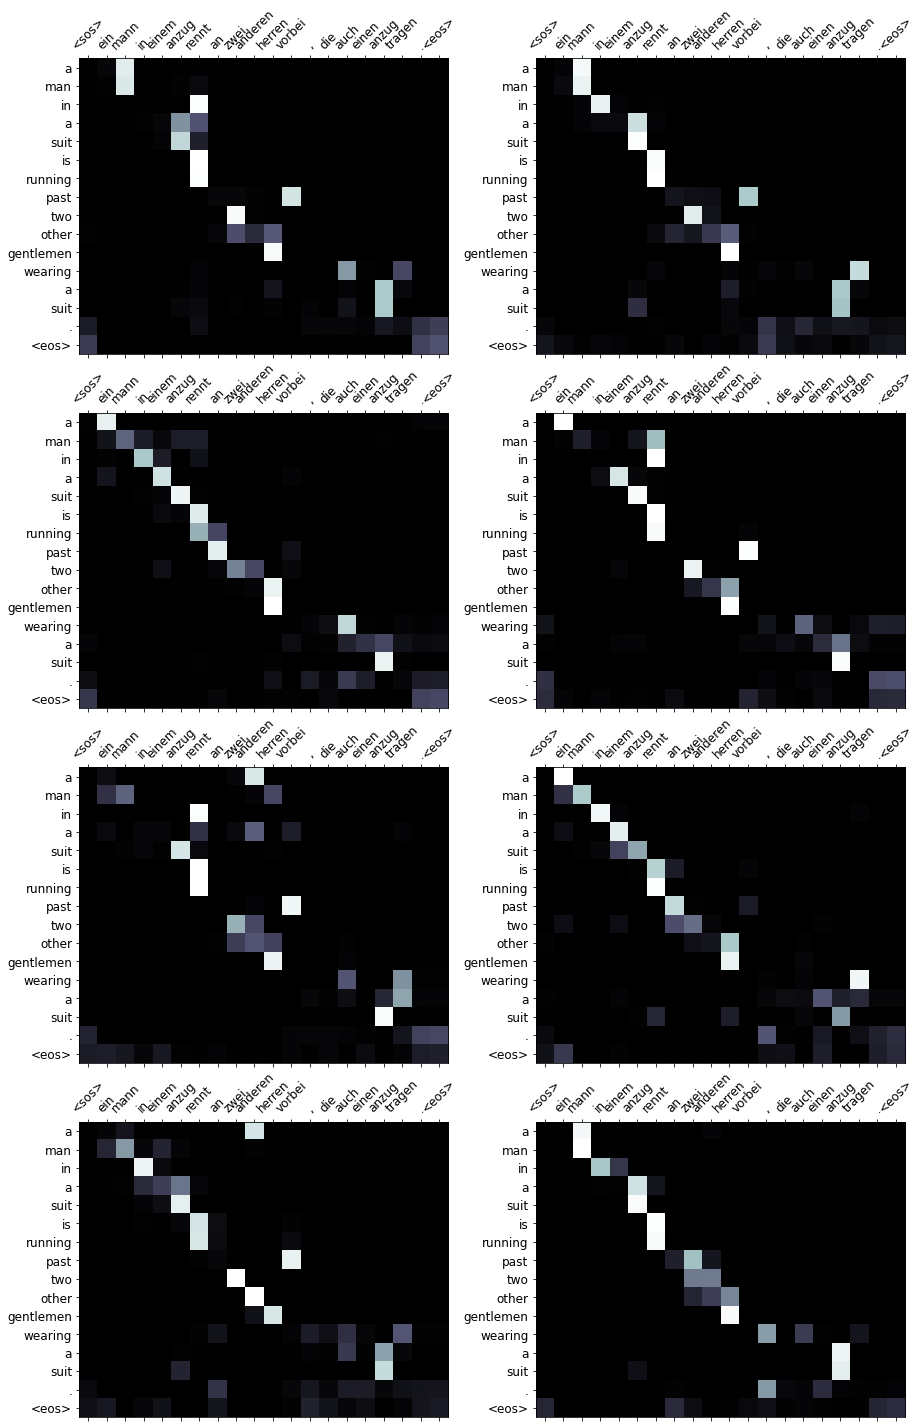

In [ ]:
display_attention(src,translation,attention)

In [ ]:
attention.shape

torch.Size([1, 8, 16, 20])

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, source, target, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.98
